In [8]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    accuracy_score,
)
import joblib


from sklearn.datasets import make_classification

plt.rcParams["figure.figsize"] = (6, 4)


In [9]:
def resolve_dataset_path(filename="churn_data.csv", env_var="CHURN_DATA_PATH", max_parent_levels=6):
    """Robustly find the dataset file.

    Returns absolute path if found, otherwise raises FileNotFoundError.
    """
    # enviorenment variable override
    env_path = os.getenv(env_var)
    if env_path:
        env_path = os.path.expanduser(env_path)
        if os.path.isfile(env_path):
            print(f"Using dataset from environment variable {env_var}: {env_path}")
            return os.path.abspath(env_path)
        else:
            print(f"{env_var} is set but file not found at: {env_path}")

    # 2) try common relative paths from current working directory and parents
    cwd = os.getcwd()
    candidates = []

    for up in range(max_parent_levels + 1):
        base = os.path.abspath(os.path.join(cwd, *([os.pardir] * up))) if up > 0 else cwd
        candidates.extend([
            os.path.join(base, "dataset", filename),
            os.path.join(base, "data", filename),
            os.path.join(base, filename),
            os.path.join(base, "notebooks", filename),
            os.path.join(base, "notebooks", "Sanjaya_FC211023", filename),
            os.path.join(base, "notebooks", "Sanjaya_FC211023", "dataset", filename),
        ])

    # also check some common mount points used in sandboxes
    candidates.extend([
        os.path.join("/workspace", filename),
        os.path.join("/workspace", "dataset", filename),
        os.path.join("/mnt", "data", filename),
        os.path.join("/mnt", "data", "dataset", filename),
        os.path.join("/home", os.getenv("USER", ""), filename),
    ])

    # Check candidates
    for p in candidates:
        if p and os.path.isfile(p):
            print("Resolved dataset at:", p)
            return os.path.abspath(p)

    # 3) shallow walk on parents (limit depth)
    for up in range(max_parent_levels + 1):
        base = os.path.abspath(os.path.join(cwd, *([os.pardir] * up))) if up > 0 else cwd
        for root, dirs, files in os.walk(base):
            if filename in files:
                found = os.path.join(root, filename)
                print("Resolved dataset via search at:", found)
                return os.path.abspath(found)

    # Not found
    tried = list(dict.fromkeys(candidates))  # unique preserving order
    print("Tried these candidate paths:")
    for p in tried:
        print("  -", p)
    raise FileNotFoundError(
        f"Could not find '{filename}'. Set {env_var} to the absolute path or place the file in a 'dataset/' folder near your project root.\n"
        f"Current working directory: {cwd}"
    )


In [10]:
data_file = None
try:
    data_file = resolve_dataset_path("churn_data.csv")
except FileNotFoundError as e:
    print("\n  Dataset not found:")
    print(e)

    if os.getenv("CHURN_FORCE_FAIL") == "1":
        raise

    # Otherwise create a small synthetic dataset as fallback
    print("\nCreating a small synthetic dataset as a fallback so you can run the notebook end-to-end.")
    print("You should replace it with your real churn_data.csv for real results.")

    n_samples = 1000
    X_syn, y_syn = make_classification(
        n_samples=n_samples,
        n_features=8,
        n_informative=4,
        n_redundant=1,
        n_clusters_per_class=1,
        weights=[0.75, 0.25],
        flip_y=0.01,
        random_state=42,
    )

    df_syn = pd.DataFrame(X_syn, columns=[f"num_feat_{i}" for i in range(X_syn.shape[1])])
    # Add a categorical-like feature by binning a numeric column
    df_syn["contract_type"] = pd.qcut(df_syn["num_feat_0"], q=3, labels=["Month-to-month", "One year", "Two year"])
    # Add a customer id column (will be removed automatically)
    df_syn["customerID"] = [f"C{10000 + i}" for i in range(n_samples)]
    df_syn["Churn"] = np.where(y_syn == 1, "Yes", "No")

    # Save synthetic CSV so subsequent runs pick it up too
    fallback_path = os.path.abspath("_synthetic_churn.csv")
    df_syn.to_csv(fallback_path, index=False)
    print(f"Synthetic dataset written to: {fallback_path}")
    data_file = fallback_path

# At this point data_file points to a valid CSV
print("\nLoading dataset from:", data_file)
df = pd.read_csv(data_file)
print("Dataset shape:", df.shape)
print(df.head(3))

# Quick sanity check
if df.shape[0] == 0 or df.shape[1] == 0:
    raise ValueError("Loaded dataset appears empty. Please provide a valid churn_data.csv file.")


Resolved dataset at: c:\Users\User\Documents\Customer_Churn_Prediction_Group_06\Customer_Churn_Prediction_Group_06\dataset\churn_data.csv

Loading dataset from: c:\Users\User\Documents\Customer_Churn_Prediction_Group_06\Customer_Churn_Prediction_Group_06\dataset\churn_data.csv
Dataset shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBil

In [11]:
PREFERRED_TARGET = "Churn"
possible_targets = [PREFERRED_TARGET, "churn", "Exited", "is_churn", "target", "label"]

target_col = None
cols_lower = {c.lower(): c for c in df.columns}
for cand in possible_targets:
    if cand.lower() in cols_lower:
        target_col = cols_lower[cand.lower()]
        print(f"Using target column: {target_col}")
        break

if target_col is None:
    # fall back to last column but warn
    target_col = df.columns[-1]
    print(f" Could not detect 'Churn' column. Falling back to last column: {target_col}")

# Drop obvious ID columns to avoid leaking
id_like = [c for c in df.columns if "id" in c.lower()]
if id_like:
    print("Dropping ID-like columns:", id_like)
    df = df.drop(columns=id_like)

X = df.drop(columns=[target_col])
y_raw = df[target_col]

# Convert to binary 0/1
if y_raw.dtype == object:
    y = y_raw.astype(str).str.strip().str.lower().map(lambda v: 1 if v in {"yes", "y", "true", "1", "churn", "exited"} else 0)
else:
    # numeric, try to coerce
    try:
        y = y_raw.astype(int)
    except Exception:
        y = pd.Series(np.where(y_raw == y_raw.iloc[0], 0, 1), index=y_raw.index)

print("\nTarget distribution:")
print(y.value_counts(dropna=False))

# Basic validation
unique_vals = sorted(y.unique())
if not set(unique_vals).issubset({0, 1}):
    raise ValueError(f"Target values are unexpected: {unique_vals}. Please make sure target is binary (Yes/No or 0/1).")


Using target column: Churn
Dropping ID-like columns: ['customerID']

Target distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)

if X_train.shape[1] == 0:
    raise ValueError("No feature columns found. Check your dataset columns.")



Train shape: (5634, 19) Test shape: (1409, 19)


In [13]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features (", len(numeric_features), "):", numeric_features)
print("Categorical features (", len(categorical_features), "):", categorical_features)


try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)


Numeric features ( 3 ): ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Categorical features ( 16 ): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']


In [14]:
svm = SVC(kernel="rbf", class_weight="balanced", random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", svm),
])

print("\nTraining SVM (this may take a bit)...")
pipeline.fit(X_train, y_train)



Training SVM (this may take a bit)...


,steps,"[('preprocessor', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



Model performance summary:
Accuracy: 0.7452093683463449
ROC-AUC: nan
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.75      0.76      1409



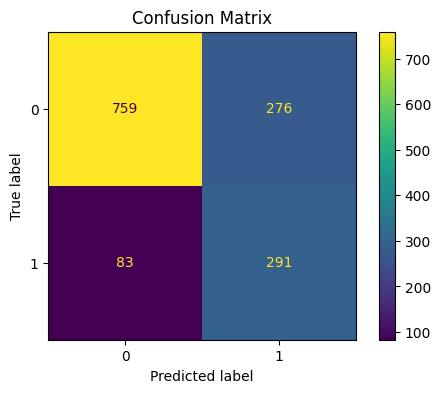

Skipping ROC plot because we could not compute probabilities.


In [15]:
y_pred = pipeline.predict(X_test)
try:
    y_prob = pipeline.predict_proba(X_test)[:, 1]
except Exception:
    # if classifier doesn't support predict_proba (shouldn't happen for SVC with probability=True)
    y_prob = np.zeros_like(y_pred, dtype=float)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob) if y_prob.sum() != 0 else float("nan")
rep = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("\nModel performance summary:")
print("Accuracy:", acc)
print("ROC-AUC:", auc)
print(rep)

# plots
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix")
plt.show()

if not np.isnan(auc):
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title("ROC Curve")
    plt.show()
else:
    print("Skipping ROC plot because we could not compute probabilities.")


In [16]:
project_root = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath(data_file)), os.pardir))
outputs_dir = os.path.join(project_root, "outputs")
models_dir = os.path.join(project_root, "models")
os.makedirs(outputs_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

metrics = {"accuracy": float(acc), "roc_auc": (None if np.isnan(auc) else float(auc))}
with open(os.path.join(outputs_dir, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

with open(os.path.join(outputs_dir, "classification_report.txt"), "w") as f:
    f.write(rep)

model_path = os.path.join(models_dir, "svm_churn_pipeline.joblib")
joblib.dump(pipeline, model_path)
print(f"\nModel saved to: {model_path}")
print(f"Metrics and report saved to: {outputs_dir}")



Model saved to: c:\Users\User\Documents\Customer_Churn_Prediction_Group_06\Customer_Churn_Prediction_Group_06\models\svm_churn_pipeline.joblib
Metrics and report saved to: c:\Users\User\Documents\Customer_Churn_Prediction_Group_06\Customer_Churn_Prediction_Group_06\outputs


In [17]:
score_val = pipeline.score(X_test, y_test)
print("Score() on test set:", score_val)
assert isinstance(score_val, float) and 0.0 <= score_val <= 1.0, "pipeline.score must be a float between 0 and 1"



# saved model file exists
assert os.path.isfile(model_path), f"Saved model not found at {model_path}"

# metrics file exists and contains accuracy
with open(os.path.join(outputs_dir, "metrics.json"), "r") as f:
    metrics_loaded = json.load(f)
assert "accuracy" in metrics_loaded, "metrics.json must contain accuracy"

# preview first 5 predictions with truth
preview = X_test.copy().reset_index(drop=True).iloc[:5].copy()
preview["y_true"] = y_test.reset_index(drop=True).iloc[:5]
preview["y_pred"] = y_pred[:5]
preview["p_churn"] = y_prob[:5]
print("\nPreview (first 5):")
print(preview)


Score() on test set: 0.7452093683463449

Preview (first 5):
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0    Male              0     Yes        Yes      72          Yes   
1  Female              1      No         No       8          Yes   
2  Female              0     Yes        Yes      41          Yes   
3    Male              0     Yes         No      18          Yes   
4  Female              0     Yes         No      72          Yes   

  MultipleLines InternetService OnlineSecurity OnlineBackup  ... StreamingTV  \
0           Yes     Fiber optic            Yes          Yes  ...         Yes   
1           Yes     Fiber optic             No           No  ...         Yes   
2           Yes             DSL            Yes          Yes  ...         Yes   
3            No     Fiber optic             No           No  ...          No   
4           Yes             DSL            Yes          Yes  ...         Yes   

  StreamingMovies        Contract PaperlessBilling

In [18]:
import joblib

joblib.dump(pipeline, "SVM_model.pkl", compress=3)

print("Model saved successfully!")

Model saved successfully!


In [19]:
feature_names = X.columns.tolist()
joblib.dump(feature_names, "feature_names.pkl")
print(f"Feature names saved! Total features: {len(feature_names)}")

print("\nFeature columns:")
for i, col in enumerate(feature_names, 1):
    print(f"{i}. {col}")

Feature names saved! Total features: 19

Feature columns:
1. gender
2. SeniorCitizen
3. Partner
4. Dependents
5. tenure
6. PhoneService
7. MultipleLines
8. InternetService
9. OnlineSecurity
10. OnlineBackup
11. DeviceProtection
12. TechSupport
13. StreamingTV
14. StreamingMovies
15. Contract
16. PaperlessBilling
17. PaymentMethod
18. MonthlyCharges
19. TotalCharges
